In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class representing a 2D Ising model
class Ising:
    def __init__(self, N, J, H):
        self.lattice = np.random.choice([-1,1], size=(N,N)) # initial state
        self.N = N # dimension
        self.J = np.abs(J) # interaction energy, non-negative by definition
        self.H = H # external field

In [3]:
# Function to calculate energy change when spin(i,j) is flipped, assuming periodic boundary conditions
def energy_change_of_flip(state, pos_i, pos_j):
    return 2*state.lattice[pos_i,pos_j]*(state.J*(state.lattice[pos_i,(pos_j+1)%state.N] + state.lattice[(pos_i-1)%state.N,pos_j] + state.lattice[(pos_i+1)%state.N,pos_j] + state.lattice[pos_i,(pos_j-1)%state.N])+state.H)

In [4]:
# Monte Carlo sweep using Metropolis algorithm
def monte_carlo_sweep(state, temperature):
    for i in range(len(state.lattice)**2):
        # pick a spin randomly and calculate energy change if it's flipped
        pos_i = np.random.randint(0,len(state.lattice))
        pos_j = np.random.randint(0,len(state.lattice))
        delta_E = energy_change_of_flip(state,pos_i,pos_j)
        
        # to flip or not to flip?
        if delta_E < 0 or np.exp(-delta_E/temperature) > np.random.random():
            state.lattice[pos_i,pos_j] *= -1

In [5]:
# Function to calculate magnetisation
def calculate_magnetisation(state):
    return np.sum(state.lattice)

In [6]:
# Function to calculate energy
def calculate_energy(state):
    interaction_energy = 0.0
    for pos_i in range(len(state.lattice)):
        for pos_j in range(len(state.lattice)):
            interaction_energy += -state.J*state.lattice[pos_i,pos_j]*(state.lattice[pos_i,(pos_j+1)%state.N] + state.lattice[(pos_i-1)%state.N,pos_j] + state.lattice[(pos_i+1)%state.N,pos_j] + state.lattice[pos_i,(pos_j-1)%state.N])
    interaction_energy *= 0.5 # avoid double counting
    
    magnetisation_energy = -state.H*calculate_magnetisation(state)
    
    return interaction_energy+magnetisation_energy

In [7]:
# Function to normalize data by number of lattice sites
def normalize_data(data, N):
    return data/(N**2)

In [8]:
# Metropolis algorithm
def Metropolis_algorithm(N_range, J, H, T_range, no_of_sweeps):
    # arrays to store magnetisation and energy time series
    M = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    E = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    M_normalized = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    E_normalized = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    
    # Monte Carlo sweeps
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            state = Ising(N_range[N_index],J,H)
            for sweep in range(no_of_sweeps): # run!
                monte_carlo_sweep(state,T_range[T_index])
                
                M[N_index,T_index,sweep] = calculate_magnetisation(state)
                E[N_index,T_index,sweep] = calculate_energy(state)
                M_normalized[N_index,T_index,sweep] = normalize_data(M[N_index,T_index,sweep],state.N)
                E_normalized[N_index,T_index,sweep] = normalize_data(E[N_index,T_index,sweep],state.N)
                
                if sweep%500 == 0: # output checkpoints
                    print('N = {0}, T = {1}, sweep = {2}'.format(N_range[N_index],T_range[T_index],sweep))
    
    return M, E, M_normalized, E_normalized

In [63]:
# Function to plot evolution of data over time
def plot_time_series(data, N_range, N_index_range, T_range, T_index_range, start_point, stop_point, xname, yname):
    for N_index in N_index_range:
        for T_index in T_index_range:
            plt.plot(range(start_point,stop_point),data[N_index,T_index,start_point:stop_point],label='N = {0}, T = {1:.3f}'.format(N_range[N_index],T_range[T_index]))
        plt.legend(loc='upper right')
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.savefig('plots/{0} vs {1} N = {2} from {3} to {4}.png'.format(yname,xname,N_range[N_index],start_point,stop_point))
        plt.figure()

In [10]:
# Function to calculate the average of a thermodynamic variable
def calculate_thermodynamic_variable(data, N_range, T_range, no_of_equilibrating_sweeps):
    var = np.zeros((len(N_range),len(T_range)))
    
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            var[N_index,T_index] = np.sum(data[N_index,T_index,no_of_equilibrating_sweeps:])/len(data[N_index,T_index,no_of_equilibrating_sweeps:])
        var[N_index,:] = normalize_data(var[N_index,:],N_range[N_index])
    
    return var

In [11]:
# Function to calculate the average of a derivative thermodynamic variable
def calculate_derivative_thermodynamic_average(data, N_range, T_range, power_of_T, no_of_equilibrating_sweeps):
    var = np.zeros((len(N_range),len(T_range)))
    
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            ave = np.sum(data[N_index,T_index,no_of_equilibrating_sweeps:])/len(data[N_index,T_index,no_of_equilibrating_sweeps:])
            squared_ave = np.sum(data[N_index,T_index,no_of_equilibrating_sweeps:]**2)/len(data[N_index,T_index,no_of_equilibrating_sweeps:])
            var[N_index,T_index] = (squared_ave-ave**2)/(T_range[T_index]**power_of_T)
        var[N_index,:] = normalize_data(var[N_index,:],N_range[N_index])
    
    return var

In [12]:
# Function to plot thermodynamic variable against temperature
def plot_temperature_dependence(data, N_range, N_index_range, T_range, T_index_range, xname, yname):
    for N_index in N_index_range:
        plt.plot(T_range[T_index_range[0]:(T_index_range[-1]+1)],data[N_index,T_index_range[0]:(T_index_range[-1]+1)],'-o',label='N = {0}'.format(N_range[N_index]))
        # +1 to include last element
    plt.legend(loc='upper right')
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.savefig('plots/{0} vs {1} from {2:.3f} to {3:.3f}.png'.format(yname,xname,T_range[T_index_range[0]],T_range[T_index_range[-1]]))
    plt.figure()

In [129]:
# Function to calculate the autocorrelation of a variable
def calculate_autocovariation(data, N_range, T_range, no_of_sweeps, no_of_equilibrating_sweeps):
    no_of_sampling_sweeps = no_of_sweeps-no_of_equilibrating_sweeps
    autocovariation = np.zeros((len(N_range),len(T_range),no_of_sampling_sweeps))
    
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            pass
    
    return autocovariation

In [14]:
# Set parameters and run the experiment!
Ns = [4, 6, 10, 14]
J = 1.0
H = 0.0
Ts = np.linspace(0.5,4.1,60) # T=2.269 will be at Ts[29]
sweeps = 4000
equilibrating_sweeps = 3000

magnetisation, energy, magnetisation_per_site, energy_per_site = Metropolis_algorithm(Ns,J,H,Ts,sweeps)

N = 4, T = 0.5, sweep = 0
N = 4, T = 0.5, sweep = 500
N = 4, T = 0.5, sweep = 1000
N = 4, T = 0.5, sweep = 1500
N = 4, T = 0.5, sweep = 2000
N = 4, T = 0.5, sweep = 2500
N = 4, T = 0.5, sweep = 3000
N = 4, T = 0.5, sweep = 3500
N = 4, T = 0.5610169491525424, sweep = 0
N = 4, T = 0.5610169491525424, sweep = 500
N = 4, T = 0.5610169491525424, sweep = 1000
N = 4, T = 0.5610169491525424, sweep = 1500
N = 4, T = 0.5610169491525424, sweep = 2000
N = 4, T = 0.5610169491525424, sweep = 2500
N = 4, T = 0.5610169491525424, sweep = 3000
N = 4, T = 0.5610169491525424, sweep = 3500
N = 4, T = 0.6220338983050847, sweep = 0
N = 4, T = 0.6220338983050847, sweep = 500
N = 4, T = 0.6220338983050847, sweep = 1000
N = 4, T = 0.6220338983050847, sweep = 1500
N = 4, T = 0.6220338983050847, sweep = 2000
N = 4, T = 0.6220338983050847, sweep = 2500
N = 4, T = 0.6220338983050847, sweep = 3000
N = 4, T = 0.6220338983050847, sweep = 3500
N = 4, T = 0.6830508474576271, sweep = 0
N = 4, T = 0.6830508474576271, swee

N = 4, T = 1.964406779661017, sweep = 0
N = 4, T = 1.964406779661017, sweep = 500
N = 4, T = 1.964406779661017, sweep = 1000
N = 4, T = 1.964406779661017, sweep = 1500
N = 4, T = 1.964406779661017, sweep = 2000
N = 4, T = 1.964406779661017, sweep = 2500
N = 4, T = 1.964406779661017, sweep = 3000
N = 4, T = 1.964406779661017, sweep = 3500
N = 4, T = 2.0254237288135593, sweep = 0
N = 4, T = 2.0254237288135593, sweep = 500
N = 4, T = 2.0254237288135593, sweep = 1000
N = 4, T = 2.0254237288135593, sweep = 1500
N = 4, T = 2.0254237288135593, sweep = 2000
N = 4, T = 2.0254237288135593, sweep = 2500
N = 4, T = 2.0254237288135593, sweep = 3000
N = 4, T = 2.0254237288135593, sweep = 3500
N = 4, T = 2.0864406779661016, sweep = 0
N = 4, T = 2.0864406779661016, sweep = 500
N = 4, T = 2.0864406779661016, sweep = 1000
N = 4, T = 2.0864406779661016, sweep = 1500
N = 4, T = 2.0864406779661016, sweep = 2000
N = 4, T = 2.0864406779661016, sweep = 2500
N = 4, T = 2.0864406779661016, sweep = 3000
N = 4, T

N = 4, T = 3.367796610169491, sweep = 3500
N = 4, T = 3.428813559322034, sweep = 0
N = 4, T = 3.428813559322034, sweep = 500
N = 4, T = 3.428813559322034, sweep = 1000
N = 4, T = 3.428813559322034, sweep = 1500
N = 4, T = 3.428813559322034, sweep = 2000
N = 4, T = 3.428813559322034, sweep = 2500
N = 4, T = 3.428813559322034, sweep = 3000
N = 4, T = 3.428813559322034, sweep = 3500
N = 4, T = 3.489830508474576, sweep = 0
N = 4, T = 3.489830508474576, sweep = 500
N = 4, T = 3.489830508474576, sweep = 1000
N = 4, T = 3.489830508474576, sweep = 1500
N = 4, T = 3.489830508474576, sweep = 2000
N = 4, T = 3.489830508474576, sweep = 2500
N = 4, T = 3.489830508474576, sweep = 3000
N = 4, T = 3.489830508474576, sweep = 3500
N = 4, T = 3.5508474576271185, sweep = 0
N = 4, T = 3.5508474576271185, sweep = 500
N = 4, T = 3.5508474576271185, sweep = 1000
N = 4, T = 3.5508474576271185, sweep = 1500
N = 4, T = 3.5508474576271185, sweep = 2000
N = 4, T = 3.5508474576271185, sweep = 2500
N = 4, T = 3.5508

N = 6, T = 1.2322033898305085, sweep = 1500
N = 6, T = 1.2322033898305085, sweep = 2000
N = 6, T = 1.2322033898305085, sweep = 2500
N = 6, T = 1.2322033898305085, sweep = 3000
N = 6, T = 1.2322033898305085, sweep = 3500
N = 6, T = 1.2932203389830508, sweep = 0
N = 6, T = 1.2932203389830508, sweep = 500
N = 6, T = 1.2932203389830508, sweep = 1000
N = 6, T = 1.2932203389830508, sweep = 1500
N = 6, T = 1.2932203389830508, sweep = 2000
N = 6, T = 1.2932203389830508, sweep = 2500
N = 6, T = 1.2932203389830508, sweep = 3000
N = 6, T = 1.2932203389830508, sweep = 3500
N = 6, T = 1.354237288135593, sweep = 0
N = 6, T = 1.354237288135593, sweep = 500
N = 6, T = 1.354237288135593, sweep = 1000
N = 6, T = 1.354237288135593, sweep = 1500
N = 6, T = 1.354237288135593, sweep = 2000
N = 6, T = 1.354237288135593, sweep = 2500
N = 6, T = 1.354237288135593, sweep = 3000
N = 6, T = 1.354237288135593, sweep = 3500
N = 6, T = 1.4152542372881354, sweep = 0
N = 6, T = 1.4152542372881354, sweep = 500
N = 6, T

N = 6, T = 2.6966101694915254, sweep = 500
N = 6, T = 2.6966101694915254, sweep = 1000
N = 6, T = 2.6966101694915254, sweep = 1500
N = 6, T = 2.6966101694915254, sweep = 2000
N = 6, T = 2.6966101694915254, sweep = 2500
N = 6, T = 2.6966101694915254, sweep = 3000
N = 6, T = 2.6966101694915254, sweep = 3500
N = 6, T = 2.7576271186440677, sweep = 0
N = 6, T = 2.7576271186440677, sweep = 500
N = 6, T = 2.7576271186440677, sweep = 1000
N = 6, T = 2.7576271186440677, sweep = 1500
N = 6, T = 2.7576271186440677, sweep = 2000
N = 6, T = 2.7576271186440677, sweep = 2500
N = 6, T = 2.7576271186440677, sweep = 3000
N = 6, T = 2.7576271186440677, sweep = 3500
N = 6, T = 2.81864406779661, sweep = 0
N = 6, T = 2.81864406779661, sweep = 500
N = 6, T = 2.81864406779661, sweep = 1000
N = 6, T = 2.81864406779661, sweep = 1500
N = 6, T = 2.81864406779661, sweep = 2000
N = 6, T = 2.81864406779661, sweep = 2500
N = 6, T = 2.81864406779661, sweep = 3000
N = 6, T = 2.81864406779661, sweep = 3500
N = 6, T = 2.

N = 10, T = 0.5, sweep = 2000
N = 10, T = 0.5, sweep = 2500
N = 10, T = 0.5, sweep = 3000
N = 10, T = 0.5, sweep = 3500
N = 10, T = 0.5610169491525424, sweep = 0
N = 10, T = 0.5610169491525424, sweep = 500
N = 10, T = 0.5610169491525424, sweep = 1000
N = 10, T = 0.5610169491525424, sweep = 1500
N = 10, T = 0.5610169491525424, sweep = 2000
N = 10, T = 0.5610169491525424, sweep = 2500
N = 10, T = 0.5610169491525424, sweep = 3000
N = 10, T = 0.5610169491525424, sweep = 3500
N = 10, T = 0.6220338983050847, sweep = 0
N = 10, T = 0.6220338983050847, sweep = 500
N = 10, T = 0.6220338983050847, sweep = 1000
N = 10, T = 0.6220338983050847, sweep = 1500
N = 10, T = 0.6220338983050847, sweep = 2000
N = 10, T = 0.6220338983050847, sweep = 2500
N = 10, T = 0.6220338983050847, sweep = 3000
N = 10, T = 0.6220338983050847, sweep = 3500
N = 10, T = 0.6830508474576271, sweep = 0
N = 10, T = 0.6830508474576271, sweep = 500
N = 10, T = 0.6830508474576271, sweep = 1000
N = 10, T = 0.6830508474576271, sweep

N = 10, T = 1.9033898305084744, sweep = 3500
N = 10, T = 1.964406779661017, sweep = 0
N = 10, T = 1.964406779661017, sweep = 500
N = 10, T = 1.964406779661017, sweep = 1000
N = 10, T = 1.964406779661017, sweep = 1500
N = 10, T = 1.964406779661017, sweep = 2000
N = 10, T = 1.964406779661017, sweep = 2500
N = 10, T = 1.964406779661017, sweep = 3000
N = 10, T = 1.964406779661017, sweep = 3500
N = 10, T = 2.0254237288135593, sweep = 0
N = 10, T = 2.0254237288135593, sweep = 500
N = 10, T = 2.0254237288135593, sweep = 1000
N = 10, T = 2.0254237288135593, sweep = 1500
N = 10, T = 2.0254237288135593, sweep = 2000
N = 10, T = 2.0254237288135593, sweep = 2500
N = 10, T = 2.0254237288135593, sweep = 3000
N = 10, T = 2.0254237288135593, sweep = 3500
N = 10, T = 2.0864406779661016, sweep = 0
N = 10, T = 2.0864406779661016, sweep = 500
N = 10, T = 2.0864406779661016, sweep = 1000
N = 10, T = 2.0864406779661016, sweep = 1500
N = 10, T = 2.0864406779661016, sweep = 2000
N = 10, T = 2.0864406779661016

N = 10, T = 3.367796610169491, sweep = 1000
N = 10, T = 3.367796610169491, sweep = 1500
N = 10, T = 3.367796610169491, sweep = 2000
N = 10, T = 3.367796610169491, sweep = 2500
N = 10, T = 3.367796610169491, sweep = 3000
N = 10, T = 3.367796610169491, sweep = 3500
N = 10, T = 3.428813559322034, sweep = 0
N = 10, T = 3.428813559322034, sweep = 500
N = 10, T = 3.428813559322034, sweep = 1000
N = 10, T = 3.428813559322034, sweep = 1500
N = 10, T = 3.428813559322034, sweep = 2000
N = 10, T = 3.428813559322034, sweep = 2500
N = 10, T = 3.428813559322034, sweep = 3000
N = 10, T = 3.428813559322034, sweep = 3500
N = 10, T = 3.489830508474576, sweep = 0
N = 10, T = 3.489830508474576, sweep = 500
N = 10, T = 3.489830508474576, sweep = 1000
N = 10, T = 3.489830508474576, sweep = 1500
N = 10, T = 3.489830508474576, sweep = 2000
N = 10, T = 3.489830508474576, sweep = 2500
N = 10, T = 3.489830508474576, sweep = 3000
N = 10, T = 3.489830508474576, sweep = 3500
N = 10, T = 3.5508474576271185, sweep = 

N = 14, T = 1.1711864406779662, sweep = 500
N = 14, T = 1.1711864406779662, sweep = 1000
N = 14, T = 1.1711864406779662, sweep = 1500
N = 14, T = 1.1711864406779662, sweep = 2000
N = 14, T = 1.1711864406779662, sweep = 2500
N = 14, T = 1.1711864406779662, sweep = 3000
N = 14, T = 1.1711864406779662, sweep = 3500
N = 14, T = 1.2322033898305085, sweep = 0
N = 14, T = 1.2322033898305085, sweep = 500
N = 14, T = 1.2322033898305085, sweep = 1000
N = 14, T = 1.2322033898305085, sweep = 1500
N = 14, T = 1.2322033898305085, sweep = 2000
N = 14, T = 1.2322033898305085, sweep = 2500
N = 14, T = 1.2322033898305085, sweep = 3000
N = 14, T = 1.2322033898305085, sweep = 3500
N = 14, T = 1.2932203389830508, sweep = 0
N = 14, T = 1.2932203389830508, sweep = 500
N = 14, T = 1.2932203389830508, sweep = 1000
N = 14, T = 1.2932203389830508, sweep = 1500
N = 14, T = 1.2932203389830508, sweep = 2000
N = 14, T = 1.2932203389830508, sweep = 2500
N = 14, T = 1.2932203389830508, sweep = 3000
N = 14, T = 1.29322

N = 14, T = 2.5745762711864404, sweep = 1500
N = 14, T = 2.5745762711864404, sweep = 2000
N = 14, T = 2.5745762711864404, sweep = 2500
N = 14, T = 2.5745762711864404, sweep = 3000
N = 14, T = 2.5745762711864404, sweep = 3500
N = 14, T = 2.6355932203389827, sweep = 0
N = 14, T = 2.6355932203389827, sweep = 500
N = 14, T = 2.6355932203389827, sweep = 1000
N = 14, T = 2.6355932203389827, sweep = 1500
N = 14, T = 2.6355932203389827, sweep = 2000
N = 14, T = 2.6355932203389827, sweep = 2500
N = 14, T = 2.6355932203389827, sweep = 3000
N = 14, T = 2.6355932203389827, sweep = 3500
N = 14, T = 2.6966101694915254, sweep = 0
N = 14, T = 2.6966101694915254, sweep = 500
N = 14, T = 2.6966101694915254, sweep = 1000
N = 14, T = 2.6966101694915254, sweep = 1500
N = 14, T = 2.6966101694915254, sweep = 2000
N = 14, T = 2.6966101694915254, sweep = 2500
N = 14, T = 2.6966101694915254, sweep = 3000
N = 14, T = 2.6966101694915254, sweep = 3500
N = 14, T = 2.7576271186440677, sweep = 0
N = 14, T = 2.7576271

N = 14, T = 3.977966101694915, sweep = 2500
N = 14, T = 3.977966101694915, sweep = 3000
N = 14, T = 3.977966101694915, sweep = 3500
N = 14, T = 4.038983050847458, sweep = 0
N = 14, T = 4.038983050847458, sweep = 500
N = 14, T = 4.038983050847458, sweep = 1000
N = 14, T = 4.038983050847458, sweep = 1500
N = 14, T = 4.038983050847458, sweep = 2000
N = 14, T = 4.038983050847458, sweep = 2500
N = 14, T = 4.038983050847458, sweep = 3000
N = 14, T = 4.038983050847458, sweep = 3500
N = 14, T = 4.1, sweep = 0
N = 14, T = 4.1, sweep = 500
N = 14, T = 4.1, sweep = 1000
N = 14, T = 4.1, sweep = 1500
N = 14, T = 4.1, sweep = 2000
N = 14, T = 4.1, sweep = 2500
N = 14, T = 4.1, sweep = 3000
N = 14, T = 4.1, sweep = 3500


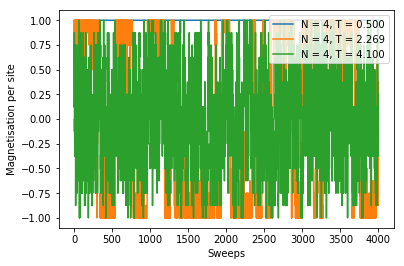

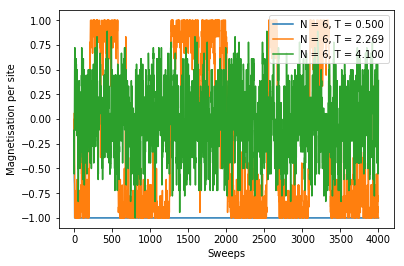

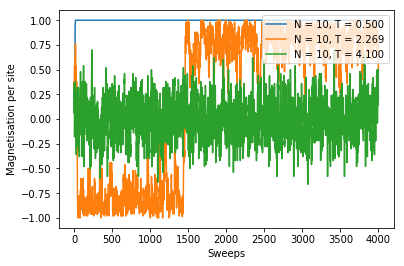

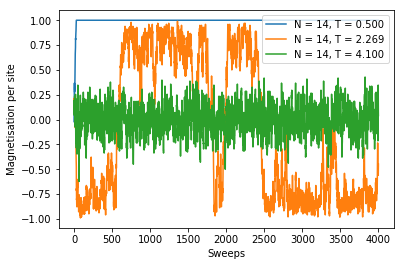

In [125]:
# Plot time evolution
N_indices = range(len(Ns))
T_indices = [0,29,59]
startpt = 0
stoppt = sweeps
plot_time_series(magnetisation_per_site,Ns,N_indices,Ts,T_indices,startpt,stoppt,'Sweeps','Magnetisation per site')

In [128]:
# How total magnetisation fluctuates with time when system is in equilibrium
magnetisation_autocovariance = calculate_autocovariation(magnetisation,Ns,Ts,sweeps,equilibrating_sweeps)

[16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16

[14. 14. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 14. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 14. 14. 14. 14. 14. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 14.
 16. 16. 16. 16. 16. 16. 16. 16. 14.  4.  0.  8. 12. 16. 16. 16. 16. 16.
 14. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 14. 14. 16. 16. 14. 16. 16. 16. 16. 16. 16. 16.
 16. 14. 16. 16. 16. 16. 16. 16. 14. 16. 14. 16. 16. 16. 14. 16. 16. 16.
 16. 16. 16. 16. 16. 14. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 14. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 14. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 14. 14. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 16.
 16. 16. 16. 16. 16. 16. 16. 16. 16. 16. 14. 16. 16

[  6.  12.  10.  16.  10.   0.  12.  10.  10.  14.  14.  12.   6.   8.
   6.  16.  14.  16.  16.  16.  16.  16.  16.  14.   6.   4.   2.   2.
  -4. -10. -12. -12.  -4.  -8. -10. -12. -14. -16.  -8. -12. -14. -10.
 -10.  -4. -12. -16. -10.  -6.   4.   0.   0.   2.   4.  -8.  -4.  -8.
  -8. -12. -14. -14.  -2.  -6. -16. -14. -12.  -4.   2.  10.   0.  -8.
  -2.  -2.   8.   8.  -6.  -8. -10.  -4.  -4. -12. -12. -14. -16. -14.
  -8.  -4.  -6. -10. -10. -16. -14. -14. -14. -16. -14. -12.  -2.  -2.
  -6.  -8.  -4.   4.  -6.  -8.   0.  10.  16.  14.  12.  12.  10.   8.
   4.  12.   8.   4.   2.  12.  12.  12.  12.   8.  16.  12.  14.  12.
  10.  10.  16.  16.  12.  10.   6.  12.  10.  12.   4.  -8.  -2.  10.
  14.  12.  12.   2.  -6.  -8. -10.  -8. -12. -10. -12.  -6. -14. -12.
 -12. -14.  -4.  -6. -12. -10. -12. -10.  -2.  -6.  -4.   4.  12.  10.
   8.   8.   8.   4.  14.  14.  16.   8.   6.   6.   0.  -8.  -8.   0.
  -4. -10.  -8.  -8.  -8.  -8. -10.  -6.  -6.  -8.  -8. -12.  -8. -10.
  -8. 

[-36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36.
 -36. -36. -36. -36. -36. -34. -32. -34. -36. -36. -36. -36. -34. -22.
 -22. -28. -32. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36.
 -36. -36. -34. -36. -36. -36. -36. -34. -36. -36. -36. -34. -36. -36.
 -36. -34. -34. -34. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36.
 -36. -36. -36. -36. -34. -36. -36. -36. -36. -36. -36. -36. -36. -36.
 -36. -36. -34. -36. -36. -36. -34. -36. -36. -36. -36. -36. -36. -36.
 -34. -36. -36. -34. -36. -36. -36. -36. -36. -36. -34. -34. -36. -36.
 -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36.
 -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36. -34.
 -36. -36. -36. -36. -34. -36. -34. -32. -34. -36. -36. -34. -36. -36.
 -36. -36. -36. -34. -34. -36. -36. -36. -36. -36. -36. -36. -36. -36.
 -36. -36. -34. -34. -36. -36. -36. -36. -36. -36. -36. -36. -36. -36.
 -36. -36. -36. -36. -36. -34. -36. -34. -34. -32. -28. -34. -32. -26.
 -34. 

[-28. -28. -28. -34. -28. -22. -32. -20. -20. -24. -22. -28. -28. -36.
 -28. -24. -30. -26. -16. -20. -16.  -4.  -6.   0.  -2.   0. -16. -18.
 -22. -26. -18. -30. -30. -22. -26. -24. -18. -16. -18. -14.  -4.   4.
  20.   8.   0.   0.  -4.   2.   2.  -8.  -2.  10.  16.  16.  10.  18.
  20.  14.  22.  10. -12. -16. -20. -16.  -8.  -6.   2.  -4.   4.  -2.
 -10. -24. -18.  -8.  -2.   8.   2.   4.   2. -14. -12. -12.   4.  22.
  22.  14.  16.  12.   4.   4.   0.  10.   8.   8.   8.   4.  16.  18.
   4.   0.   6.  14.   6.  20.  30.  30.  28.  36.  26.  22.  16.  18.
  10.   4.   8.  12.   6.   8.  12.  16.   8. -14. -10.  -6. -20.  -4.
   4.   0.   4.  12.   8.   4.   0.   0.   4.  -2. -10. -16. -20. -14.
 -30. -26. -14. -22. -20. -16. -30. -22. -14. -14. -20.   0.  -6.   0.
   6.  -4.  -4. -14. -16. -28. -28. -30. -20. -18. -22. -36. -36. -34.
 -26. -32. -22. -24. -14. -10.  -8.   0.   0.  -6.   4.   0.  -6.  -2.
  -4.   2.   0.  12.  10.   8.   8.  -2.   0.   8.  -6.  -8. -26. -32.
 -28. 

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100.  98. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100.  98. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.  98.  98.
  98.  98. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.  98. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 

[-74. -64. -56. -52. -34. -50. -44. -54. -78. -62. -52. -34. -26. -28.
 -24. -44. -34. -28. -32. -32. -18. -12. -10. -10.   4.  -4.   6.  24.
  28.  32.  46.  42.  22.  18.  30.  34.  12.  10.  -2.  20.  32.  44.
  32.  58.  68.  70.  68.  60.  46.  48.   8. -10.  -2.   2.   8.  14.
  22.  34.  48.  46.  32.  28.  20.  22.  44.  44.  32.  44.  48.  36.
  62.  62.  62.  42.  42.  32.  36.  52.  72.  62.  58.  54.  40.  50.
  70.  82.  84.  80.  78.  80.  72.  60.  68.  66.  66.  68.  64.  68.
  72.  48.  46.  36.  56.  44.  52.  36.  40.  20.   2.   4.  14.  20.
  26.  34.  36.  42.  44.  40.  50.  66.  56.  66.  54.  58.  50.  68.
  64.  64.  66.  34.  52.  42.  56.  62.  52.  52.  52.  66.  54.  50.
  52.  56.  50.  46.  70.  56.  60.  54.  56.  50.  50.  38.  46.  54.
  56.  38.  20.   0.  20.  24.   0. -12.   4.  12.  10.  -4.  12.  18.
  32.  10. -20. -18. -26. -32. -38. -54. -42. -40. -54. -68. -70. -76.
 -60. -56. -56. -58. -42. -50. -32. -34. -54. -48. -42. -48. -52. -54.
 -40. 

[196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 194. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 194. 196. 196.
 196. 196. 196. 196. 196. 196. 194. 194. 194. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 194. 196. 196. 196. 196. 196. 196. 196. 194.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196.
 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 196. 194. 194.
 194. 196. 196. 196. 196. 196. 196. 196. 196. 194. 196. 196. 196. 196.
 196. 

[180. 180. 182. 184. 188. 176. 166. 182. 174. 148. 152. 146. 142. 138.
 154. 166. 186. 172. 166. 176. 172. 172. 156. 174. 160. 156. 152. 168.
 160. 150. 158. 168. 164. 166. 166. 168. 168. 162. 168. 176. 176. 180.
 182. 184. 184. 190. 180. 172. 174. 176. 180. 182. 188. 180. 168. 154.
 166. 152. 160. 148. 144. 144. 162. 152. 146. 154. 170. 160. 158. 158.
 172. 172. 176. 186. 188. 176. 170. 166. 168. 168. 164. 168. 186. 182.
 178. 186. 174. 180. 172. 176. 174. 162. 182. 182. 178. 194. 194. 176.
 176. 166. 176. 162. 168. 168. 184. 180. 178. 166. 184. 182. 176. 160.
 176. 176. 176. 176. 188. 188. 188. 192. 182. 190. 192. 190. 188. 184.
 166. 176. 184. 194. 190. 184. 192. 192. 186. 190. 178. 182. 180. 178.
 168. 168. 178. 188. 186. 178. 186. 180. 182. 186. 178. 186. 186. 172.
 172. 148. 130. 126. 134. 148. 146. 140. 134. 128. 132. 126. 132. 134.
 136. 132. 132. 126. 134. 142. 132. 140. 150. 156. 156. 150. 162. 164.
 170. 138. 126. 140. 134. 134. 140. 124. 112. 120. 122. 116. 126. 144.
 162. 

[ 16.   0. -14.  -6.  24.  58.  22.  22.  14.  26.  42.  66.  40.  16.
  -8.  -8.   4.  32.  -2. -14. -24.  -6. -38. -24.   6.  12.  28.  44.
  50.  48.  16.  28.  16.  12.  -4. -18. -12. -10. -20. -50. -58. -50.
 -74. -72. -68. -72. -62. -30. -46. -44. -40. -30.  -8. -16. -22.  12.
  34.  56.  78.  62.  80.  78.  54.  32.   6.   6.  14.  14.  -4. -26.
  32.  24.  24.   0.  10.  32.  22. -14.  -4.  10.  22.   8.   4.   0.
  20. -18.   8.  18.   8. -18.  14.   2.   0. -14.  20.  46.  38.  20.
   4.  24.  24.  18.   6.  -4.  -4. -16. -20.  -6.  20.  18.  46.  52.
  48.  40.  16.  -4. -16. -40. -52. -26. -10. -20. -30.  12.  52.  42.
  18.  34.  22.  26.   4. -28.   6. -12.  10.  14.  24.  32.   4.   8.
  -4. -24. -34. -42. -30. -34. -16. -24. -36.  -8.  12. -12. -30. -34.
 -14. -38. -16. -18.  10.   8.  38.  18.  -2.  22.  14.   8.  12.  -4.
 -16. -14. -30.   2.   2.  -8.  10.   2.  -2. -22. -22.  34.  10.   6.
  12.  30.  10.   8.  -6. -22. -42. -34. -18.  12.   2. -14. -22. -32.
  -8. 

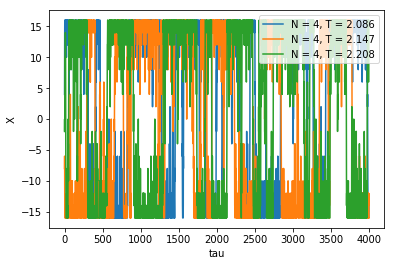

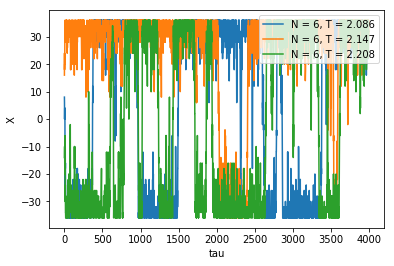

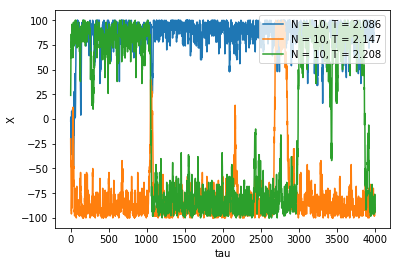

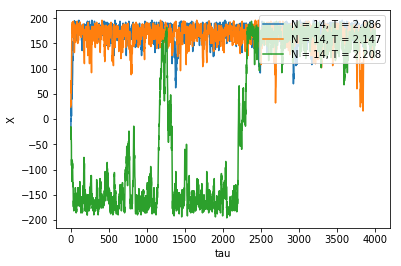

In [124]:
# Plot autocovariance of total magnetisation
N_indices = range(len(Ns))
T_indices = range(26,29)
'''startpt = 1
stoppt = sweeps-equilibrating_sweeps
plot_time_series(np.abs(magnetisation_autocovariance),Ns,N_indices,Ts,T_indices,startpt,stoppt,'tau','Autocorrelation')'''
plot_time_series(magnetisation,Ns,N_indices,Ts,T_indices,startpt,stoppt,'tau','X')

In [126]:
# Calculate thermodynamic variables
average_magnetisation = calculate_thermodynamic_variable(np.abs(magnetisation),Ns,Ts,equilibrating_sweeps)
average_energy = calculate_thermodynamic_variable(energy,Ns,Ts,equilibrating_sweeps)
average_susceptibility = calculate_derivative_thermodynamic_average(np.abs(magnetisation),Ns,Ts,1,equilibrating_sweeps)
average_heat_capacity = calculate_derivative_thermodynamic_average(energy,Ns,Ts,2,equilibrating_sweeps)

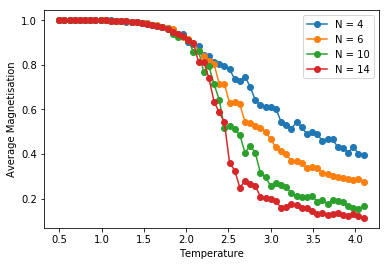

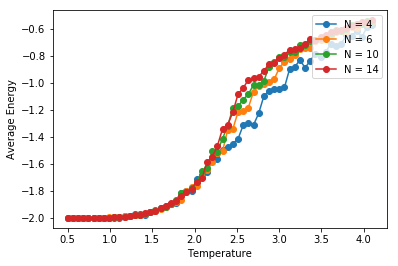

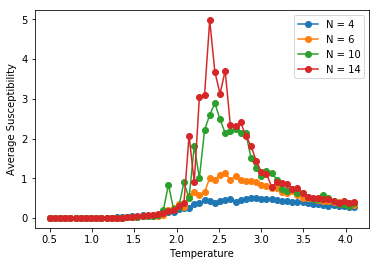

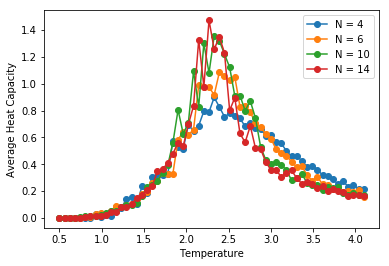

In [127]:
# Plot thermodynamic variables
N_indices = range(len(Ns))
T_indices = range(len(Ts))
plot_temperature_dependence(average_magnetisation,Ns,N_indices,Ts,T_indices,'Temperature','Average Magnetisation')
plot_temperature_dependence(average_energy,Ns,N_indices,Ts,T_indices,'Temperature','Average Energy')
plot_temperature_dependence(average_susceptibility,Ns,N_indices,Ts,T_indices,'Temperature','Average Susceptibility')
plot_temperature_dependence(average_heat_capacity,Ns,N_indices,Ts,T_indices,'Temperature','Average Heat Capacity')